In [1]:
import numpy as np
from scipy import signal
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage.interpolation import shift
import scipy.interpolate as interpolate
import itertools as it
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba
from lab.misc.auto_helpers import locate
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%run Helper_Functions.ipynb

In [ ]:
return_all = []
for mousename in ['BV150', 'BV151', 'BV152', 'BV153', 'BV154', 'BV160', 'BV163', 'BV165', \
                  'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    exptListAll = [expt for expt in dbMouse(mousename).imagingExperiments() if \
                   (expt.experimentType == 'rippleActivity') or \
                    expt.experimentType == 'PreGOL' or expt.experimentType == 'PreSatiety']
    
    print(str(len(exptListAll)) + ' experiments:')
    count = 0
    for rippleGroup in np.sort(np.unique((map(lambda x: x.rippleGrp, exptListAll)))):
        dataBuffer = []
        for expt_num in np.where((map(lambda x: x.rippleGrp == rippleGroup, exptListAll)))[0]:
            print(str(count)+ ', ' ),
            count = count + 1
            
            expt = exptListAll[expt_num]
            ripple_frames = loadRippleFrames(expt)

            if len(ripple_frames) > 0:
                dff = expt.imagingData(dFOverF='from_file', label='all_fissa')[:,:,0]
                df = pd.read_excel('/data2/bert/CA3/Histology/RippleMice/' + mousename + '_subtypes.xlsx', \
                               sheet_name='group' + str(expt.rippleGrp))
                try:
                    imaging_planes = ROI_planeID(expt, 'all_fissa')
                except:
                    imaging_planes = np.arange(dff.shape[0])
            
                window_size_in_sec = 3.00
                window_size_in_frames = int(np.rint(1/expt.frame_period() * window_size_in_sec))
                for icell in range(dff.shape[0]):
                    traces = []
                    for rtime in ripple_frames:
                        if ((window_size_in_frames < rtime) & (rtime < (expt.num_frames() - window_size_in_frames))):
                            peri_ripple_trace = dff[icell, (rtime - window_size_in_frames):(rtime + window_size_in_frames)]
                            if len(peri_ripple_trace) > 0:
                                peri_ripple_trace = stats.zscore(peri_ripple_trace)
                                traces.append(peri_ripple_trace)
                    dataBuffer.append({'roiID': imaging_planes[icell], 
                                   'type': df['Subtype'][imaging_planes[icell]], 
                                   'region': df['Region'][imaging_planes[icell]],
                                   'layer': df['Layer'][imaging_planes[icell]],
                                   'CB': df['CB'][imaging_planes[icell]],
                                   'SATB1': df['SATB1'][imaging_planes[icell]], 
                                   'n_ripples': len(ripple_frames),
                                   'trace': np.nanmean(traces, axis = 0)})   
            else:
                continue
        dataBuffer = pd.DataFrame(dataBuffer)
        for planenumber in filter(lambda v: v==v, np.unique(dataBuffer['roiID'])):
            expt_traces = []
            for array in dataBuffer[dataBuffer.roiID == planenumber]['trace'].values:
                expt_traces.append(array)
            expt_traces = np.asarray(expt_traces)
            
            n_ripples = np.nansum(dataBuffer[dataBuffer.roiID == planenumber]['n_ripples'])
            return_all.append({'mouse': mousename, 'grp': rippleGroup, 
                            'Imaging_Plane': planenumber,
                            'Subtype': dataBuffer[dataBuffer.roiID == planenumber]['type'].iloc[0], 
                            'Avg_Trace': np.nanmean(expt_traces, axis = 0), 
                            'n_ripples': n_ripples,
                            'CB': dataBuffer[dataBuffer.roiID == planenumber]['CB'].iloc[0],
                            'SATB1': dataBuffer[dataBuffer.roiID == planenumber]['SATB1'].iloc[0],
                            'Region': dataBuffer[dataBuffer.roiID == planenumber]['region'].iloc[0],
                            'Layer': dataBuffer[dataBuffer.roiID == planenumber]['layer'].iloc[0]})  

return_all = pd.DataFrame(return_all)
filename = 'Peri_Ripple_Traces_3s_Window_All_Mice.pkl'
outfile = open(filename, 'wb')
pickle.dump(return_all, outfile)
outfile.close()

In [3]:
with open('Peri_Ripple_Traces_3s_Window_All_Mice.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
data = data[data.Region != 'CA1']
data = data.replace(to_replace = 'Bistr', value = 'SOM')
data = data.replace(to_replace = 'SOM/CB', value = 'SOM')
data = data.replace(to_replace = 'CA2/CA3', value = 'CA3')

In [5]:
data = data[data.Region == 'CA3']
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
data = data[data.Subtype.isin(subtypes)]

(75, 600)
(71, 600)
(114, 600)
(32, 600)
(22, 600)


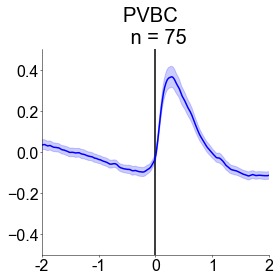

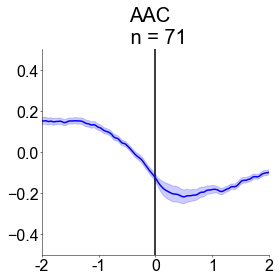

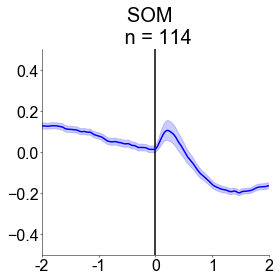

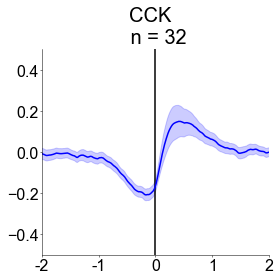

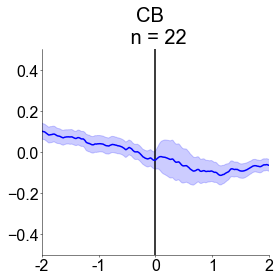

In [6]:
data = data[~pd.isnull(data.Avg_Trace)]
mean_traces = []
sem_traces = []
for i, subtype in enumerate(subtypes):
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    traces= []
    for n, array in enumerate(data[data.Subtype == subtype].Avg_Trace.values):
        traces.append(array)
    resample_traces = []
    for arr in traces:
        resample_traces.append(resample_trace(arr, 600))
    resample_traces = np.asarray(resample_traces)
    mean = np.nanmean(resample_traces, axis = 0)
    mean_traces.append(mean)
    
    sem = stats.sem(resample_traces, axis = 0, nan_policy = 'omit')
    sem_traces.append(sem)
    print resample_traces.shape

    ax.axvline(x = resample_traces.shape[1]/2, color = 'black')
    ax.plot(mean, color = 'blue')
    ax.fill_between(np.arange(0, mean.shape[0]), \
        mean - sem, mean + sem, color = 'blue', alpha = 0.2)
    ax.set_title(subtype + ' ' + \
            ' \n n = ' + str(resample_traces.shape[0]), fontsize = 20)
    ax.tick_params(axis = 'x', labelsize = 16)
    ax.tick_params(axis = 'y', labelsize = 16)
    ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
    ax.set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
    ax.set_xlim([100,500])
    ax.set_ylim([-0.5, 0.5])
    #ax[i].set_yticklabels([])
    simpleaxis(ax)
    
    fig.tight_layout()
    plt.savefig('CA3_SWR_Activity{}.svg'.format(i), format = 'svg', \
                dpi = 1200, transparent = True)

(75, 600)
(71, 600)
(114, 600)
(32, 600)
(22, 600)


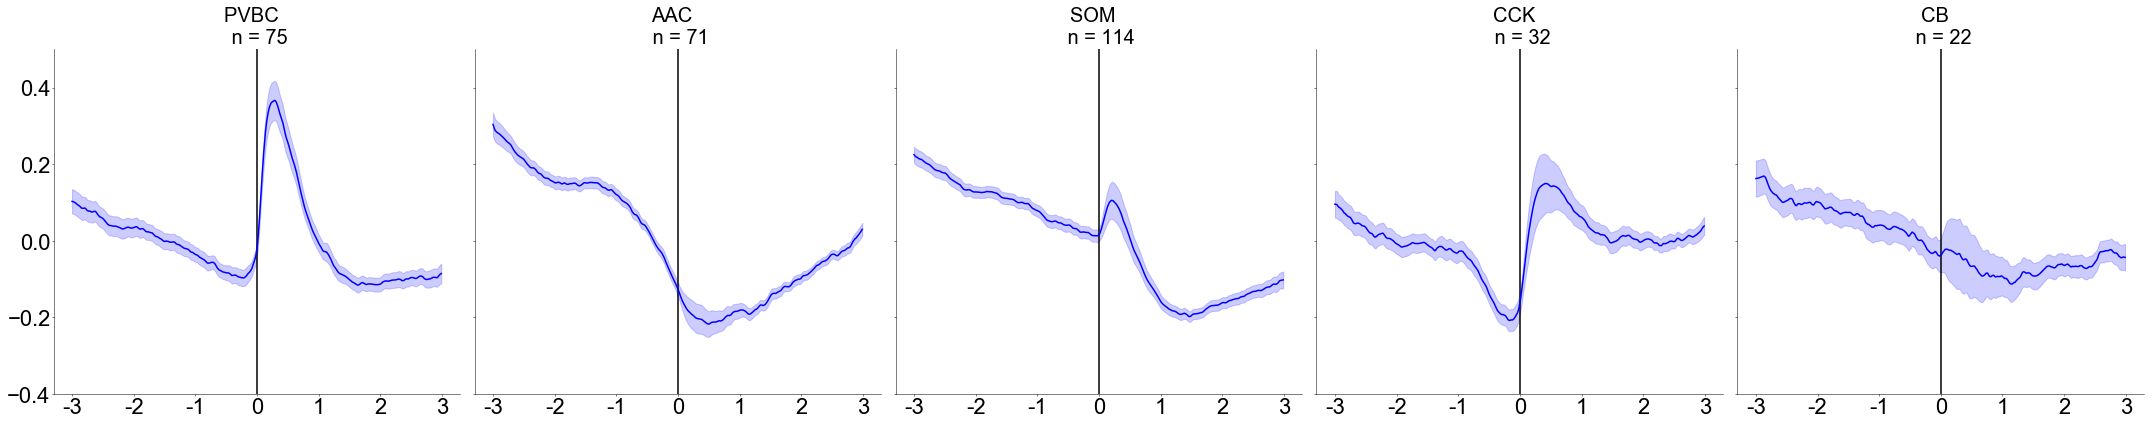

In [7]:
fig, ax = plt.subplots(1, 5, figsize = (30, 6), sharey = True)

data = data[~pd.isnull(data.Avg_Trace)]
mean_traces = []
sem_traces = []
for i, subtype in enumerate(subtypes):
    traces= []
    for n, array in enumerate(data[data.Subtype == subtype].Avg_Trace.values):
        traces.append(array)
    resample_traces = []
    for arr in traces:
        resample_traces.append(resample_trace(arr, 600))
    resample_traces = np.asarray(resample_traces)
    mean = np.nanmean(resample_traces, axis = 0)
    mean_traces.append(mean)
    
    sem = stats.sem(resample_traces, axis = 0, nan_policy = 'omit')
    sem_traces.append(sem)
    print resample_traces.shape

    ax[i].axvline(x = resample_traces.shape[1]/2, color = 'black')
    ax[i].plot(mean, color = 'blue')
    ax[i].fill_between(np.arange(0, mean.shape[0]), \
        mean - sem, mean + sem, color = 'blue', alpha = 0.2)
    ax[i].set_title(subtype + ' ' + \
            ' \n n = ' + str(resample_traces.shape[0]), fontsize = 20)
    ax[i].tick_params(axis = 'x', labelsize = 22)
    ax[i].tick_params(axis = 'y', labelsize = 22)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600])
    ax[i].set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
    ax[i].set_ylim([-0.4, 0.5])
    #ax[i].set_yticklabels([])
    simpleaxis(ax[i])

fig.tight_layout()
plt.savefig('CA3_SWR_Activity_by_Subtype_Vertical.svg', format = 'svg', \
            dpi = 1200, transparent = True)

/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


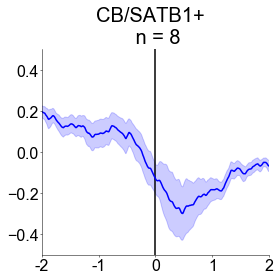

In [8]:
CB_SATB1_pos_traces = []
for n, array in enumerate(data[data.Subtype == 'CB'][data.SATB1 == '+'].Avg_Trace.values):
    CB_SATB1_pos_traces.append(array)
resample_CB_SATB1_pos_traces = []
for arr in CB_SATB1_pos_traces:
    resample_CB_SATB1_pos_traces.append(resample_trace(arr, 600))
resample_CB_SATB1_pos_traces = np.asarray(resample_CB_SATB1_pos_traces)

pos_mean = np.nanmean(resample_CB_SATB1_pos_traces, axis = 0)
pos_sem = stats.sem(resample_CB_SATB1_pos_traces, axis = 0, nan_policy = 'omit')

fig, ax = plt.subplots(1, 1, figsize = (4,4))

ax.axvline(x = resample_CB_SATB1_pos_traces.shape[1]/2, color = 'black')
ax.plot(pos_mean, color = 'blue')
ax.fill_between(np.arange(0, pos_mean.shape[0]), \
    pos_mean - pos_sem, pos_mean + pos_sem, color = 'blue', alpha = 0.2)
ax.set_title('CB/SATB1+ ' + ' \n n = ' + str(resample_CB_SATB1_pos_traces.shape[0]), fontsize = 20)
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
ax.set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([100,500])
simpleaxis(ax)

fig.tight_layout()
plt.savefig('CA3_CB_SATB1_Positive_PSTH.svg', format = 'svg', \
            dpi = 1200, transparent = True)

/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


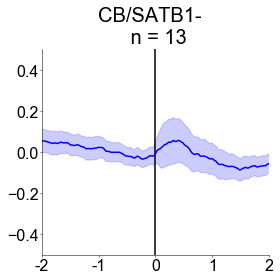

In [9]:
CB_SATB1_neg_traces = []
for n, array in enumerate(data[data.Subtype == 'CB'][data.SATB1 == '-'].Avg_Trace.values):
    CB_SATB1_neg_traces.append(array)
resample_CB_SATB1_neg_traces = []
for arr in CB_SATB1_neg_traces:
    resample_CB_SATB1_neg_traces.append(resample_trace(arr, 600))
resample_CB_SATB1_neg_traces = np.asarray(resample_CB_SATB1_neg_traces)

neg_mean = np.nanmean(resample_CB_SATB1_neg_traces, axis = 0)
neg_sem = stats.sem(resample_CB_SATB1_neg_traces, axis = 0, nan_policy = 'omit')

fig, ax = plt.subplots(1, 1, figsize = (4,4))
ax.axvline(x = resample_CB_SATB1_neg_traces.shape[1]/2, color = 'black')
ax.plot(neg_mean, color = 'blue')
ax.fill_between(np.arange(0, neg_mean.shape[0]), \
    neg_mean - neg_sem, neg_mean + neg_sem, color = 'blue', alpha = 0.2)
ax.set_title('CB/SATB1- ' + ' \n n = ' + str(resample_CB_SATB1_neg_traces.shape[0]), fontsize = 20)
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xticks([0, 100, 200, 300, 400, 500, 600])
ax.set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([100,500])
simpleaxis(ax)

fig.tight_layout()
plt.savefig('CA3_CB_SATB1_Negative_PSTH.svg', format = 'svg', \
            dpi = 1200, transparent = True)